### Import Requirements

In [32]:
import pandas as pd
import numpy as np
import gzip
import json
import re
import string
import nltk
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore") #, category=DeprecationWarning
from sklearn.feature_extraction.text import TfidfVectorizer

#Change2: !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_colwidth', 500)

### Data Exploration

In [33]:
# Load Office Product Amazon Reviews as pandasDF
def parse(path):
    g = gzip.open(path, "rb")
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

data_path = "Office_Products_5.json.gz" #Change1: "../Office_Products_5.json.gz"
data = getDF(data_path)

This Dataset is an updated version of the Amazon review dataset released in 2014. As in the previous version, this dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). In addition, this version provides the following features:

More reviews:
The total number of reviews is 233.1 million (142.8 million in 2014).
Newer reviews:
Current data includes reviews in the range May 1996 - Oct 2018.
Metadata:
We have added transaction metadata for each review shown on the review page. Such information includes:
Product information, e.g. color (white or black), size (large or small), package type (hardcover or electronics), etc.
Product images that are taken after the user received the product.
Added more detailed metadata of the product landing page. Such detailed information includes:
Bullet-point descriptions under product title.
Technical details table (attribute-value pairs).
Similar products table.
More categories:
Includes 5 new product categories.

Source: https://nijianmo.github.io/amazon/index.html#code

In [34]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",1510012800,NaN,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,1488844800,NaN,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,1466812800,NaN,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,1456012800,NaN,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,1438473600,NaN,NaN


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800357 entries, 0 to 800356
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         800357 non-null  float64
 1   verified        800357 non-null  bool   
 2   reviewTime      800357 non-null  object 
 3   reviewerID      800357 non-null  object 
 4   asin            800357 non-null  object 
 5   style           501427 non-null  object 
 6   reviewerName    800217 non-null  object 
 7   reviewText      800144 non-null  object 
 8   summary         800228 non-null  object 
 9   unixReviewTime  800357 non-null  int64  
 10  vote            88817 non-null   object 
 11  image           11302 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 74.0+ MB


In [36]:
data.describe()

# Observation1: Average of review rating is around 4.47 which might imply that dataset contains more positive reviews.

,overall,unixReviewTime
count,800357.000000,8.003570e+05
mean,4.471100,1.442901e+09
std,1.015676,5.853007e+07
min,1.000000,9.396000e+08
25%,4.000000,1.415664e+09
50%,5.000000,1.451952e+09
75%,5.000000,1.483056e+09
max,5.000000,1.538438e+09


In [37]:
# Considered only required columns for further analysis
df = data[["reviewerID","asin","overall","reviewText","summary"]]
df['reviewText'].head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                         kids like story BUT while i really wanted a board book this one is just so small.  wish larger
1                                                                                                                                                                                                                                                                                           Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter c

In [38]:
print("Count of null values: ", df['reviewText'].isnull().sum())

# Observation2: Fetch the indexes of null values
nullIndexes = df[df['reviewText'].isnull()].index.tolist()
for i,j in enumerate(nullIndexes):
    print(df['reviewText'][j])

Count of null values:  213
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [39]:
df["overall"].value_counts()

# Observation3: Dataset need to be balanced

5.0    570993
4.0    122889
3.0     50702
1.0     31697
2.0     24076
Name: overall, dtype: int64

In [40]:
df[df["reviewText"].isnull()].overall.value_counts()

# # Observation4: Most of the null values in review column are for high ratings. 
# Options to handle null values: Filling with a constant value, delete those rows, or text imputation techniques

5.0    184
4.0     25
3.0      2
2.0      2
Name: overall, dtype: int64

In [41]:
# Initial trail deleting the rows with null values
'''
Verify the summary column is null if reviewText is null
'''

df.dropna(subset=['reviewText'], inplace=True)

In [42]:
print("Count of null values after the action: ",df["reviewText"].isnull().sum(), "\n")
df.info()

Count of null values after the action:  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800144 entries, 0 to 800356
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewerID  800144 non-null  object 
 1   asin        800144 non-null  object 
 2   overall     800144 non-null  float64
 3   reviewText  800144 non-null  object 
 4   summary     800030 non-null  object 
dtypes: float64(1), object(4)
memory usage: 36.6+ MB


## Visualization
### Distribution of the number of reviews across products

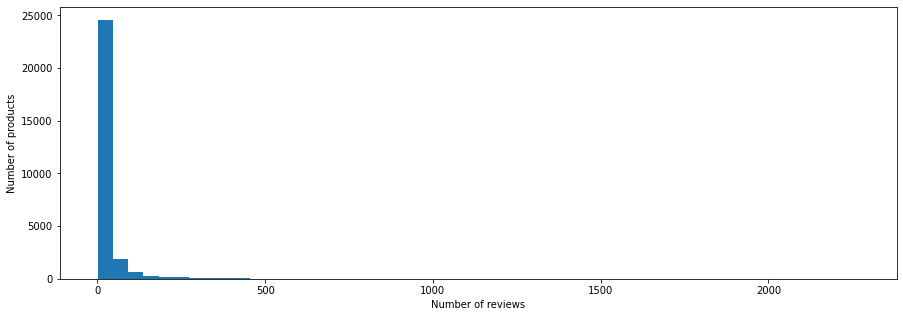

In [43]:
# Group the reviews by product ID and count the number of reviews per product
reviews_per_product = df['asin'].value_counts()

plt.figure(figsize=(15,5))
# Visualize the distribution of the number of reviews across products using a histogram
plt.hist(reviews_per_product, bins=50)
plt.xlabel('Number of reviews')
plt.ylabel('Number of products')
plt.show()

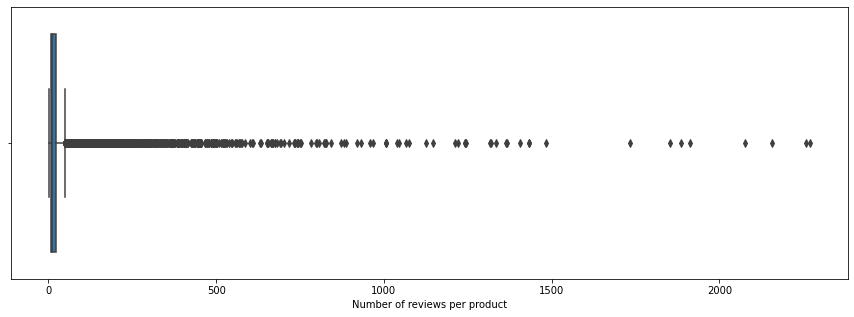

In [44]:
# Group the reviews by product ID and count the number of reviews per product
reviews_per_product_df = df.groupby('asin').size().reset_index(name='review_count')

plt.figure(figsize=(15,5))
# Visualize the distribution of the number of reviews per product using a box plot
sns.boxplot(x=reviews_per_product_df['review_count'])
plt.xlabel('Number of reviews per product')
plt.show()

<AxesSubplot: ylabel='Count'>

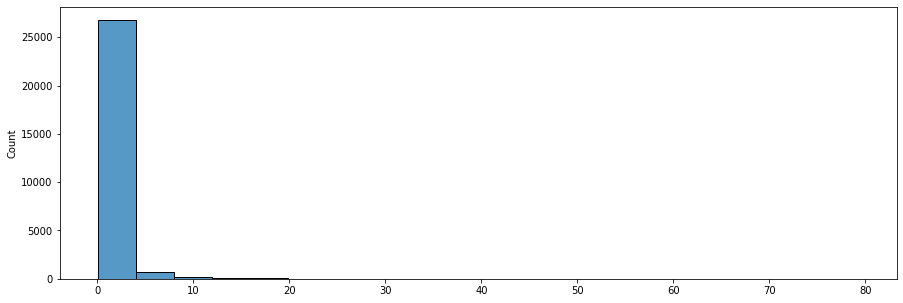

In [45]:
# Calculate the average number of reviews per product
reviews_per_product_df_ = df.groupby('asin').size()
avg_reviews_per_product = reviews_per_product_df_.mean()

plt.figure(figsize=(15,5))
# Plot the distribution of reviews per product
sns.histplot(reviews_per_product_df_/avg_reviews_per_product, bins=20)

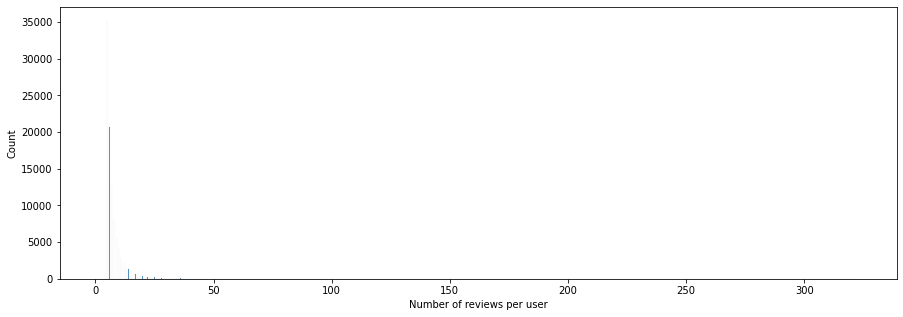

In [46]:
# Group the reviews by user ID and count the number of reviews per user
reviews_per_user = df.groupby('reviewerID').size().reset_index(name='review_count')

plt.figure(figsize=(15,5))
# Visualize the distribution of the number of reviews per user using a histogram
sns.histplot(x=reviews_per_user['review_count'])
plt.xlabel('Number of reviews per user')
plt.show()

<AxesSubplot: xlabel='review_count', ylabel='Density'>

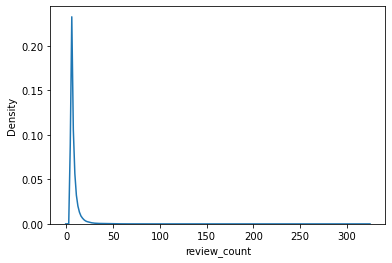

In [47]:
sns.kdeplot(reviews_per_user['review_count'])

In [48]:
avg_reviews_per_product, reviews_per_product_df_

(28.612336849633472,
 asin
 0140503528    11
 0310432065    15
 0310520347    22
 0310802636    19
 0310806607    16
               ..
 B01HH8E2QA    10
 B01HHLLLIO     5
 B01HI60F6C     5
 B01HIL946E     5
 B01HINS07G    55
 Length: 27965, dtype: int64)

## Pre-processing


    Text cleaning (removing punctuation, special characters, etc.)
    Lowercasing the text
    Tokenization (splitting the text into individual words or tokens)
    Stopword removal (removing common words like "the" or "and")
    Lemmatization (reducing words to their base form)

In [50]:
# remove punctuations and digits from reviewText, and lowercasing the text
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return re.sub(r'\d+','', text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
# Tokenize the sentences in the review column
df['cleanText'] = df['reviewText'].apply(clean_text)
df.head()

,reviewerID,asin,overall,reviewText,summary,cleanText
0,A2NIJTYWADLK57,0140503528,4.0,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",kids like story but while i really wanted a board book this one is just so small wish larger
1,A2827D8EEURMP4,0140503528,4.0,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,bought this used and it came in great condition almost like it had never been read the story isnt as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection
2,APB6087F4J09J,0140503528,5.0,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,every story and book about corduroy is fantastic this book is great and i bought all the corduroy books for my boys and now for their total of children you have to buy a corduroy bear for everyone who has the books love to hold them while the stories are read
3,A2DHERRZIPFU7X,0140503528,5.0,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,i purchased this book for my first grade classroom i read the book to the students during a math lesson the first day i split the students into groups and had them count how many pockets they had all together they recorded it on a chart and answered questions like who had the most who had the least choose two numbers and compare using the second day we referenced the book and compared pockets of the boys vs the girls they again answered questions about the numbers they loved it recommend
4,A2XCLJRGFANRC,0140503528,5.0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,having spent numerous years in an elementary school library i can say with all honesty that the corduroy books were great favorites for all the years i was there a pocket for corduroy is a charming addition to anyones collection it is a very sweet story about the owner of corduroy who leaves him in the laundry and has some difficulties retrieving him children can relate to that quite well getting him back is a good lesson in itself sewing the pocket on for him is delightful it has a happy en...


### Sentence Tokenization on review column

## Install spacy package
!pip install spacy or !pip install spacy==3.0.5 --user
!python -m spacy download en_core_web_sm
- df['sentences'] = df['sentencesToWords'].apply(lambda x: [sent.text for sent in nlp(x).sents])

___Plan was to implement with spaCy but this library was taking very long time with the available resources. Resulted in choosing nltk library which is quick___

In [ ]:
'''# import spacy
#nlp = spacy.load("en_core_web_sm")

from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

def sentenceToWord(sentences):
    tokenized_words = []
    for sentence in sentences:
        doc = tokenizer(sentence)
        tokens = [token.text for token in doc]
        tokenized_words.append(tokens)
    return tokenized_words
'''

In [57]:
stopwords = nltk.corpus.stopwords.words("english")

def sentencesToWord(text):
    tokenized_words = []
    # Text to Sentences
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        # Sentence to Word i.e., tokens
        tokens = nltk.word_tokenize(sentence)
        # Remove stop words from tokens
        for i in tokens:
            if not i in stopwords:
                    tokenized_words.append(i)
        #tokenized_corpus_without_stopwords = [i for i in tokens if not i in stopwords]
        #tokenized_words.append(tokenized_corpus_without_stopwords)
    
    return tokenized_words

In [58]:
# Tokenize the sentences in the review column
df['tokens'] = df['cleanText'].apply(sentencesToWord)
df.head()

,reviewerID,asin,overall,reviewText,summary,cleanText,tokens
0,A2NIJTYWADLK57,0140503528,4.0,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",kids like story but while i really wanted a board book this one is just so small wish larger,"[kids, like, story, really, wanted, board, book, one, small, wish, larger]"
1,A2827D8EEURMP4,0140503528,4.0,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,bought this used and it came in great condition almost like it had never been read the story isnt as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection,"[bought, used, came, great, condition, almost, like, never, read, story, isnt, good, original, corduroy, husband, version, child, add, daughter, collection]"
2,APB6087F4J09J,0140503528,5.0,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,every story and book about corduroy is fantastic this book is great and i bought all the corduroy books for my boys and now for their total of children you have to buy a corduroy bear for everyone who has the books love to hold them while the stories are read,"[every, story, book, corduroy, fantastic, book, great, bought, corduroy, books, boys, total, children, buy, corduroy, bear, everyone, books, love, hold, stories, read]"
3,A2DHERRZIPFU7X,0140503528,5.0,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,i purchased this book for my first grade classroom i read the book to the students during a math lesson the first day i split the students into groups and had them count how many pockets they had all together they recorded it on a chart and answered questions like who had the most who had the least choose two numbers and compare using the second day we referenced the book and compared pockets of the boys vs the girls they again answered questions about the numbers they loved it recommend,"[purchased, book, first, grade, classroom, read, book, students, math, lesson, first, day, split, students, groups, count, many, pockets, together, recorded, chart, answered, questions, like, least, choose, two, numbers, compare, using, second, day, referenced, book, compared, pockets, boys, vs, girls, answered, questions, numbers, loved, recommend]"
4,A2XCLJRGFANRC,0140503528,5.0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,having spent numerous years in an elementary school library i can say with all honesty that the corduroy books were great favorites for all the years i was there a pocket for corduroy is a charming addition to anyones collection it is a very sweet story about the owne

In [55]:
from nltk.corpus import wordnet

# Function to convert POS tag from Treebank to WordNet format
def get_wordnet_pos(treebank_pos):
    if treebank_pos.startswith('J'):
        return wordnet.ADJ
    elif treebank_pos.startswith('V'):
        return wordnet.VERB
    elif treebank_pos.startswith('N'):
        return wordnet.NOUN
    elif treebank_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [60]:
def lemmatizer(tokens):
    # Initialize lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each word with its POS tag
    lemmatized_words = []
    for word, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemma)

    return lemmatized_words

text = "The dogs are barking outside. I'm trying to focus on my work."

print(lemmatizer(['kids', 'like', 'story', 'really', 'wanted', 'board', 'book', 'one', 'small', 'wish', 'larger']))

['kid', 'like', 'story', 'really', 'want', 'board', 'book', 'one', 'small', 'wish', 'large']


In [62]:
# Tokenize the sentences in the review column
df['tokens'] = df['tokens'].apply(lemmatizer)
df.head()

,reviewerID,asin,overall,reviewText,summary,cleanText,tokens
0,A2NIJTYWADLK57,0140503528,4.0,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",kids like story but while i really wanted a board book this one is just so small wish larger,"[kid, like, story, really, want, board, book, one, small, wish, large]"
1,A2827D8EEURMP4,0140503528,4.0,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,bought this used and it came in great condition almost like it had never been read the story isnt as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection,"[bought, use, come, great, condition, almost, like, never, read, story, isnt, good, original, corduroy, husband, version, child, add, daughter, collection]"
2,APB6087F4J09J,0140503528,5.0,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,every story and book about corduroy is fantastic this book is great and i bought all the corduroy books for my boys and now for their total of children you have to buy a corduroy bear for everyone who has the books love to hold them while the stories are read,"[every, story, book, corduroy, fantastic, book, great, buy, corduroy, book, boy, total, child, buy, corduroy, bear, everyone, book, love, hold, story, read]"
3,A2DHERRZIPFU7X,0140503528,5.0,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved ...",Great for Math!,i purchased this book for my first grade classroom i read the book to the students during a math lesson the first day i split the students into groups and had them count how many pockets they had all together they recorded it on a chart and answered questions like who had the most who had the least choose two numbers and compare using the second day we referenced the book and compared pockets of the boys vs the girls they again answered questions about the numbers they loved it recommend,"[purchase, book, first, grade, classroom, read, book, student, math, lesson, first, day, split, student, group, count, many, pocket, together, record, chart, answered, question, like, least, choose, two, number, compare, use, second, day, reference, book, compare, pocket, boys, vs, girl, answer, question, number, love, recommend]"
4,A2XCLJRGFANRC,0140503528,5.0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a ...",Love Corduroy,having spent numerous years in an elementary school library i can say with all honesty that the corduroy books were great favorites for all the years i was there a pocket for corduroy is a charming addition to anyones collection it is a very sweet story about the owner of corduroy who leaves him in the 

In [ ]:
# more preprocessing
## distribution graph
## limitization, stemming (week2)
## LaMDA ()?

In [74]:
# a. Randomly select 500-1000 reviews from your dataset and perform steps b through d.
n_samples = random.randint(500, 1000)
review_samples = df.sample(n=n_samples)
review_samples

,reviewerID,asin,overall,reviewText,summary,sentencesToWords
309084,A1AVTWQT4YOGH0,B001B0CP74,1.0,"This item is NOT as advertised! I've received two that have no pockets. Exchanged for replacement and it was duplicated, no pockets!",NO Pockets!,"[[This, item, is, NOT, as, advertised, !], [I, 've, received, two, that, have, no, pockets, .], [Exchanged, for, replacement, and, it, was, duplicated, ,, no, pockets, !]]"
28552,A3QB8J0ZJC4R25,B00006B80P,5.0,Good quality.,Five Stars,"[[Good, quality, .]]"
709350,A1V4BXWE7G47S4,B01AKCA0GQ,5.0,Nice replacement pack but wish we could also order the cartridges seperately,Five Stars,"[[Nice, replacement, pack, but, wish, we, could, also, order, the, cartridges, seperately]]"
245488,A2QEJWC32S2YCR,B0016P2A5G,5.0,WORKS AS ADVERTIZED!!\nED,Five Stars,"[[WORKS, AS, ADVERTIZED, !, !], [ED]]"
799289,A2O1EWK4R2JWKQ,B01EX4KMNI,2.0,"One of the three templates broke within a month. I kept the template in the pocket of my hard-back Moleskine where it was protected. Apart from lack of durability, these are good templates.",these are good templates.,"[[One, of, the, three, templates, broke, within, a, month, .], [I, kept, the, template, in, the, pocket, of, my, hard-back, Moleskine, where, it, was, protected, .], [Apart, from, lack, of, durability, ,, these, are, good, templates, .]]"
...,...,...,...,...,...,...
144885,A3O2FR42OX3D6O,B000ANLD1M,4.0,"Timesaver over my old print, xyron and tape method for my Etsy shop. Only complaint (I should have read the description better!) is that every label has to be trimmed somewhat. I naively assumed that shipping labels were a standard size, since the labels on my Amazon purchases seemed perfect.\nOverall I think I will like them better as time goes on. I still save money also since the xyron was wayyyyy more costly, plus I no longer am using all that tape.",Good - not perfect for me.,"[[Timesaver, over, my, old, print, ,, xyron, and, tape, method, for, my, Etsy, shop, .], [Only, complaint, (, I, should, have, read, the, description, better, !, )], [is, that, every, label, has, to, be, trimmed, somewhat, .], [I, naively, assumed, that, shipping, labels, were, a, standard, size, ,, since, the, labels, on, my, Amazon, purchases, seemed, perfect, .], [Overall, I, think, I, will, like, them, better, as, time, goes, on, .], [I, still, save, money, also, since, the, xyron, was, ..."
653802,A1AGSD0KWRLLSH,B00VY9U9W0,5.0,"Wow. That is all I can say.\n\nWell I guess I can say some more :D\nThese pens are thoroughly impressive! They are sleek, beautiful, and come in vibrant colours. When i draw with them, they produce a clear, precise line. If they came in different sizes of nibs, i would easily have these over Sakura Microns ^.^ due to how quickly they dry (i couldn't make them smudge, even while trying very hard to smudge it directly after applying the ink to the page), and unlike the Microns, they don't leak...","beautiful, and come in vibrant colours","[[Wow, .], [That, is, all, I, can, say, .], [Well, I, guess, I, can, say, some, more, :, D, These, pens, are, thoroughly, impressive, !], [They, are, sleek, ,, beautiful, ,, and, come, in, vibrant, colours, .], [When, i, draw, with, them, ,, they, produce, a, clear, ,, precise, line, .], [If, they, came, in, different, sizes, of, nibs, ,, i, would, easily, have, these, over, Sakura, Microns, ^.^, due, to, how, quickly, they, dry, (, i, could, n't, make, them, smudge, ,, even, while, trying, ..."
524780,AEQETO9WVO3XR,B00D5BL2DK,5.0,I use these pens for school and for every subject. They erase completely and the ink dries very quickly. These are light weight and they write so smoothly. If you need to erase a lot such as when taking lecture notes these will work for you. I only wish that the ink would not run out as fast as it does.,My favorite pens.,"[[I, use, these, pens, for, school, and, for, every, subject, .], [They, erase, completely, and, the, ink, dries, very, quickly, .], [These, are, light, weight, and, they, w

In [75]:
#b. Label your data based on the value of “rating of the product” i.e. as follows:
    #i. Ratings 4,5: Positive
    #ii. Rating 3: Neutral
    #iii. Ratings 1,2: Negative

# Create new column
review_samples.insert(1, "sentiment", np.nan)
review_samples

,reviewerID,sentiment,asin,overall,reviewText,summary,sentencesToWords
309084,A1AVTWQT4YOGH0,NaN,B001B0CP74,1.0,"This item is NOT as advertised! I've received two that have no pockets. Exchanged for replacement and it was duplicated, no pockets!",NO Pockets!,"[[This, item, is, NOT, as, advertised, !], [I, 've, received, two, that, have, no, pockets, .], [Exchanged, for, replacement, and, it, was, duplicated, ,, no, pockets, !]]"
28552,A3QB8J0ZJC4R25,NaN,B00006B80P,5.0,Good quality.,Five Stars,"[[Good, quality, .]]"
709350,A1V4BXWE7G47S4,NaN,B01AKCA0GQ,5.0,Nice replacement pack but wish we could also order the cartridges seperately,Five Stars,"[[Nice, replacement, pack, but, wish, we, could, also, order, the, cartridges, seperately]]"
245488,A2QEJWC32S2YCR,NaN,B0016P2A5G,5.0,WORKS AS ADVERTIZED!!\nED,Five Stars,"[[WORKS, AS, ADVERTIZED, !, !], [ED]]"
799289,A2O1EWK4R2JWKQ,NaN,B01EX4KMNI,2.0,"One of the three templates broke within a month. I kept the template in the pocket of my hard-back Moleskine where it was protected. Apart from lack of durability, these are good templates.",these are good templates.,"[[One, of, the, three, templates, broke, within, a, month, .], [I, kept, the, template, in, the, pocket, of, my, hard-back, Moleskine, where, it, was, protected, .], [Apart, from, lack, of, durability, ,, these, are, good, templates, .]]"
...,...,...,...,...,...,...,...
144885,A3O2FR42OX3D6O,NaN,B000ANLD1M,4.0,"Timesaver over my old print, xyron and tape method for my Etsy shop. Only complaint (I should have read the description better!) is that every label has to be trimmed somewhat. I naively assumed that shipping labels were a standard size, since the labels on my Amazon purchases seemed perfect.\nOverall I think I will like them better as time goes on. I still save money also since the xyron was wayyyyy more costly, plus I no longer am using all that tape.",Good - not perfect for me.,"[[Timesaver, over, my, old, print, ,, xyron, and, tape, method, for, my, Etsy, shop, .], [Only, complaint, (, I, should, have, read, the, description, better, !, )], [is, that, every, label, has, to, be, trimmed, somewhat, .], [I, naively, assumed, that, shipping, labels, were, a, standard, size, ,, since, the, labels, on, my, Amazon, purchases, seemed, perfect, .], [Overall, I, think, I, will, like, them, better, as, time, goes, on, .], [I, still, save, money, also, since, the, xyron, was, ..."
653802,A1AGSD0KWRLLSH,NaN,B00VY9U9W0,5.0,"Wow. That is all I can say.\n\nWell I guess I can say some more :D\nThese pens are thoroughly impressive! They are sleek, beautiful, and come in vibrant colours. When i draw with them, they produce a clear, precise line. If they came in different sizes of nibs, i would easily have these over Sakura Microns ^.^ due to how quickly they dry (i couldn't make them smudge, even while trying very hard to smudge it directly after applying the ink to the page), and unlike the Microns, they don't leak...","beautiful, and come in vibrant colours","[[Wow, .], [That, is, all, I, can, say, .], [Well, I, guess, I, can, say, some, more, :, D, These, pens, are, thoroughly, impressive, !], [They, are, sleek, ,, beautiful, ,, and, come, in, vibrant, colours, .], [When, i, draw, with, them, ,, they, produce, a, clear, ,, precise, line, .], [If, they, came, in, different, sizes, of, nibs, ,, i, would, easily, have, these, over, Sakura, Microns, ^.^, due, to, how, quickly, they, dry, (, i, could, n't, make, them, smudge, ,, even, while, trying, ..."
524780,AEQETO9WVO3XR,NaN,B00D5BL2DK,5.0,I use these pens for school and for every subject. They erase completely and the ink dries very quickly. These are light weight and they write so smoothly. If you need to erase a lot such as when taking lecture notes these will work for you. I only wish that the ink would not run out as fast as it does.,My favorite pens.,"[[I, use, these, pens, for, school, and, for, every, subject, .], [They, erase, completely, and, the, ink, dries, very, quickly

In [76]:
# Label the sentimental values
for index, row in review_samples.iterrows():
    #i. Ratings 4,5: Positive
    if (row.overall >= 4.):
        print(index, "positive")
        review_samples.loc[index, ["sentiment"]] = "positive"
    #ii. Rating 3: Neutral
    elif (row.overall < 4. or row.overall > 2.):
        print(index, "neutral")
        review_samples.loc[index, ["sentiment"]] = "neutral"
    #iii. Ratings 1,2: Negative
    elif (row.overall <= 2.):
        print(index, "negative")
        review_samples.loc[index, ["sentiment"]] = "negative"

309084 neutral
28552 positive
709350 positive
245488 positive
799289 neutral
289626 positive
133710 positive
196580 positive
455947 positive
762200 positive
612687 positive
390612 positive
691731 positive
349936 positive
629736 positive
483763 positive
386420 positive
595094 positive
272137 positive
262913 positive
30168 positive
179790 positive
73842 positive
543242 neutral
737000 positive
363071 positive
153585 positive
113061 positive
37006 positive
46902 positive
780860 positive
630436 positive
482855 positive
540459 positive
206380 neutral
341129 positive
370522 neutral
218302 positive
174240 positive
19034 positive
595897 neutral
318249 positive
723370 positive
686272 positive
776289 positive
18042 positive
373796 positive
100342 positive
411405 positive
769569 neutral
452669 neutral
664385 positive
234050 positive
32085 positive
708165 neutral
735790 positive
105964 positive
732012 neutral
297474 positive
281394 positive
738844 positive
545715 positive
427161 positive
479045 pos

In [78]:
review_samples["sentiment"].isnull().any()

False

In [79]:
review_samples["reviewText"].isnull().any()

False

### Sampling: perform stratified sampling to ensure that the samples in the training and testing sets are balanced across the different groups

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['reviewText', 'clean_text']], df['group'], test_size=0.2, stratify=df['group'])

In [76]:
#c. Chose the appropriate columns for your sentiment analyzer. (Give this some thought)

### Text Representation

In [84]:
# Apply TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(review_samples["reviewText"])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(542, 2618)
['', '03mm', '05', '05mm', '062pg', '07', '1', '10', '100', '1000', '1012', '10hour', '11', '114', '1162a', '11x14', '12', '127', '13', '14', '15', '150', '16', '18', '1982', '1year', '2', '20', '200', '2000', '2014', '2015', '23', '24', '25', '26', '2b', '3', '30', '300', '301', '307', '30odd', '30sec', '314', '32016', '3349a', '34', '35mm', '38', '388', '3m', '3ring', '4', '40', '48', '4999', '4pli', '4x12', '4x6', '4yo', '5', '50', '500', '53', '57', '5th', '6', '60', '61', '61xl', '62', '64bit', '6520', '682017', '6pack', '7', '701', '71', '74x', '75', '7inch', '7mm', '8', '80', '835', '845', '85x11', '8x10', '9', '90', '92', '93', '96', '9913', '9mm', 'abil', 'abl', 'absolut', 'absorbt', 'abysm', 'accept', 'acceptablebett', 'access', 'accid', 'accident', 'accommod', 'accordingli', 'acct', 'accur', 'ach', 'achiev', 'across', 'action', 'actual', 'ad', 'add', 'addit', 'address', 'adequ', 'adher', 'adhes', 'adivertis', 'adjac', 'adjust', 'adquat', 'adult', 'advanc', 'adver

### Modeling (Lexicon-based approach)

In [122]:
# Valence Aware Dictionary and Sentiment Reasoner (VADR)
VADR_analyzer = SentimentIntensityAnalyzer()
# Pass the analyzer for head 5 rows
for index, row in review_samples.head().iterrows():
    vs = VADR_analyzer.polarity_scores(row["reviewText"])
    print(
        f"Index: {index}\n"+
        f"Sentimental Analysis Result: {vs}\n"+
        f"Overall rating category: {row.sentiment}\n"+
        f"Full Text:\n{row.reviewText}\n"+
        "-"*50)

Index: 778312
Sentimental Analysis Result: {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'compound': 0.3612}
Overall rating category: positive
Full Text:
They work like they are supposed to... I use them in my work as a teacher...
--------------------------------------------------
Index: 528188
Sentimental Analysis Result: {'neg': 0.0, 'neu': 0.185, 'pos': 0.815, 'compound': 0.6588}
Overall rating category: positive
Full Text:
Great product!
--------------------------------------------------
Index: 88978
Sentimental Analysis Result: {'neg': 0.028, 'neu': 0.781, 'pos': 0.191, 'compound': 0.7814}
Overall rating category: positive
Full Text:
Hard to get excited over writing implements, but these are my personal favorite pens.  Can't speak for the pricing vs. local stores, but they showed up in one day and the convenience is worth a small upcharge.
--------------------------------------------------
Index: 602569
Sentimental Analysis Result: {'neg': 0.039, 'neu': 0.828, 'pos': 0.133, 'compound':

### Validation